<a href="https://colab.research.google.com/github/03aquamarine/YuJin-s/blob/main/%2303_0725Tue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#자연어 이해를 활용한 고객 지원 트윗 분석 및 대응 전략 개발

- 자연어 이해(NLU) 및 대화 모델을 활용하여 고객 지원 트위터 데이터 세트를 분석하고, 이를 바탕으로 고객 지원에 대한 통찰력을 얻고 대응 전략을 개발하는 것입니다.

- 데이터: https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter

- 필요 기술 스택: Python, Python Library(Pandas, Matplotlib, Seaborn), Machine Learning
Finetuning + Openai API


#1. Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk

In [3]:
raw_twcs = pd.read_csv('/content/drive/MyDrive/Dataset/#03_tweets/twcs/twcs.csv', encoding='utf-8')

## 1.1 First data exploration

In [4]:
raw_twcs.sample(10)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1956055,2111388,AppleSupport,False,Wed Nov 08 16:29:32 +0000 2017,@622776 Thanks for reaching out. We want to he...,2111389,2111390.0
297194,339468,197061,True,Sat Oct 07 23:35:03 +0000 2017,@AmazonHelp ああ、これはどうもご丁寧にすみません。どうせいつかは登録しようとは思...,339467,339469.0
744971,832580,318298,True,Fri Oct 13 05:53:57 +0000 2017,@GWRHelp why’s the 0645 Kemble to Paddington s...,832579,NaN
2668257,2841499,790657,True,Mon Nov 27 15:57:29 +0000 2017,@ChipotleTweets should do breakfast.,2841498,NaN
1358000,1494702,393478,True,Mon Oct 16 23:33:51 +0000 2017,@Ask_WellsFargo Lol,NaN,1494701.0
943287,1046490,airtel_care,False,Mon Oct 23 10:26:57 +0000 2017,"@367370 Hello, your line has been worked on. P...",NaN,1046491.0
41450,52086,127711,True,Wed Nov 01 17:42:04 +0000 2017,@VirginAtlantic what’s the deal with your webs...,52084,NaN
1510458,1657719,AppleSupport,False,Mon Nov 06 04:27:56 +0000 2017,@505670 Here’s what you can do to work around ...,"1657720,1657721",1657722.0
2366697,2533928,721036,True,Mon Oct 30 16:15:04 +0000 2017,@AppleSupport 11.,2533930,2533927.0
2365431,2532676,123555,True,Thu Nov 16 06:23:30 +0000 2017,@5699 @116450 @Delta @135156 @AmericanAir @264...,2532673,2532677.0


In [5]:
raw_twcs.shape

(2811774, 7)

In [6]:
raw_twcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB


In [7]:
raw_twcs.isnull()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
2811769,False,False,False,False,False,True,False
2811770,False,False,False,False,False,False,True
2811771,False,False,False,False,False,True,False
2811772,False,False,False,False,False,True,False


In [8]:
raw_twcs.isnull().sum()

tweet_id                         0
author_id                        0
inbound                          0
created_at                       0
text                             0
response_tweet_id          1040629
in_response_to_tweet_id     794335
dtype: int64

# 2. Feature Extraction
- pandas를 사용하여 트위터 고객 서비스 데이터(raw_twcs)를 처리하기

In [11]:
# first_inbound = 처음으로 들어오는 고객의 요청 트윗
# 'in_response_to_tweet_id' 열이 결측치(null)이고 'inbound' 열이 True인 행들을 선택
first_inbound = raw_twcs[pd.isnull(raw_twcs.in_response_to_tweet_id) & raw_twcs.inbound]

# 'first_inbound' 데이터프레임과 'raw_twcs' 데이터프레임을 'tweet_id' 열과 'in_response_to_tweet_id' 열을 기준으로 병합(merge)
# 즉, 처음 들어오는 고객의 요청 트윗에 대해 그에 대한 회사의 응답 트윗을 찾음
inbound = pd.merge(first_inbound, raw_twcs, left_on='tweet_id',
                                  right_on='in_response_to_tweet_id').sample(frac=1)  # 모든 행을 무작위로 샘플링

# 'inbound_y' 열이 True가 아닌 경우에 해당하는 행들만 선택
# 'inbound_y' 열은 회사의 응답 트윗인데, 이 행들을 선택하여 고객으로부터의 응답이 아닌 회사에서의 응답만 남게 됨
inbound = inbound[inbound.inbound_y ^ True]

In [12]:
inbound.shape

(794299, 14)

In [13]:
inbound

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
650052,2250181,655594,True,Tue Nov 14 10:50:59 +0000 2017,Fingers crossed for #Windows10 creator updatin...,"2250182,2250180",NaN,2250182,MicrosoftHelps,False,Tue Nov 14 12:28:26 +0000 2017,@655594 How's the new update? If you have any ...,NaN,2250181.0
532984,1892020,564174,True,Wed Oct 18 12:08:57 +0000 2017,And this is why I only fly @SouthwestAir..sitt...,1892019,NaN,1892019,AmericanAir,False,Wed Oct 18 12:14:06 +0000 2017,@564174 We'll be wheels up and on our way as q...,NaN,1892020.0
53756,207675,165112,True,Sun Nov 19 15:46:13 +0000 2017,@115940 i have spotify premium for students an...,207674,NaN,207674,hulu_support,False,Sun Nov 19 17:15:30 +0000 2017,"@165112 Sorry to hear about this, Ryann! Chat ...",NaN,207675.0
704089,2426379,696749,True,Tue Nov 14 19:04:44 +0000 2017,I like how @118706 can deliver something corre...,2426378,NaN,2426378,UPSHelp,False,Tue Nov 14 19:08:00 +0000 2017,@696749 Is there anything that my team can che...,NaN,2426379.0
770873,2645703,746449,True,Fri Nov 17 19:46:42 +0000 2017,Not only did my driver not come to the door bu...,2645702,NaN,2645702,Uber_Support,False,Fri Nov 17 19:52:04 +0000 2017,@746449 We're sorry to hear this was your expe...,NaN,2645703.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335075,1221418,406605,True,Mon Oct 16 00:09:24 +0000 2017,@Postmates_Help my order was never delivered I...,1221416,NaN,1221416,Postmates_Help,False,Mon Oct 16 00:11:30 +0000 2017,@406605 Can you DM us so we can take a look?,1221417,1221418.0
760654,2613653,622193,True,Fri Nov 17 12:55:53 +0000 2017,Ooooh @VirginTrains do you not want to take th...,2613651,NaN,2613651,VirginTrains,False,Fri Nov 17 12:56:38 +0000 2017,"@622193 This has been reported, Laura ^MW",2613652,2613653.0
228886,846845,321266,True,Fri Oct 20 13:36:14 +0000 2017,"@AmazonHelp @116928 Hello there, I had a probl...",846844,NaN,846844,AmazonHelp,False,Fri Oct 20 13:43:33 +0000 2017,@321266 I'm sorry that you haven't received yo...,846843,846845.0
874272,2985215,823155,True,Sat Nov 25 08:50:06 +0000 2017,@ATVIAssist Hey @115754 im having trouble gett...,"2985214,2985216",NaN,2985214,ATVIAssist,False,Thu Nov 30 06:25:35 +0000 2017,"@823155 please contact by DM, providing your G...",NaN,2985215.0


> 각 라인에 고객 요청(text_x), 회사로부터의 답변(text_y)가 포함되어 데이터셋의 크기가 두 배로 커짐

> 'inbound_x'는 항상 True,
'inbound_y'는 항상 False

## 2.1 Drop useless features

In [14]:
inbound.columns

Index(['tweet_id_x', 'author_id_x', 'inbound_x', 'created_at_x', 'text_x',
       'response_tweet_id_x', 'in_response_to_tweet_id_x', 'tweet_id_y',
       'author_id_y', 'inbound_y', 'created_at_y', 'text_y',
       'response_tweet_id_y', 'in_response_to_tweet_id_y'],
      dtype='object')

In [15]:
# 제거할 columns list
toDrop = ['tweet_id_x', 'inbound_x','response_tweet_id_x', 'in_response_to_tweet_id_x',
          'tweet_id_y', 'inbound_y','response_tweet_id_y', 'in_response_to_tweet_id_y']

In [16]:
# 필요없는 columns 제거
inbound.drop(toDrop, axis=1, inplace=True)
print('inbound shape: ', inbound.shape)

inbound shape:  (794299, 6)


In [17]:
inbound.sample(5)

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y
142581,245265,Sat Dec 02 15:03:30 +0000 2017,Great customer service from Holly at @O2 store...,O2,Sat Dec 02 15:08:42 +0000 2017,@245265 That's what we like to hear Will 😃 If ...
590017,609500,Sat Oct 07 15:47:15 +0000 2017,"Hey @115900, how about some internet that work...",comcastcares,Sat Oct 07 17:54:28 +0000 2017,@609500 Hello. You can definitely feel free t...
834505,793585,Sun Nov 26 22:42:07 +0000 2017,"El operador en @115993 @122343 me dice ""su ca...",AskPayPal,Mon Nov 27 20:47:43 +0000 2017,@793585 Hola. Nos gustaría revisar tu situació...
747340,503387,Mon Oct 30 14:03:23 +0000 2017,@Morrisons just a small request can you ask th...,Morrisons,Mon Oct 30 16:38:49 +0000 2017,"@503387 Hi there, I have passed on your reques..."
152220,254415,Sun Dec 03 04:31:18 +0000 2017,@115877 - customer service number please your ...,Uber_Support,Sun Dec 03 04:34:51 +0000 2017,"@254415 At this moment, we don't offer phone s..."


## 2.2 Companies
- Seaborn 라이브러리를 사용하여 DataFrame 'inbound'에서 회사의 응답 수 분포에 대한 count plot을 만듦

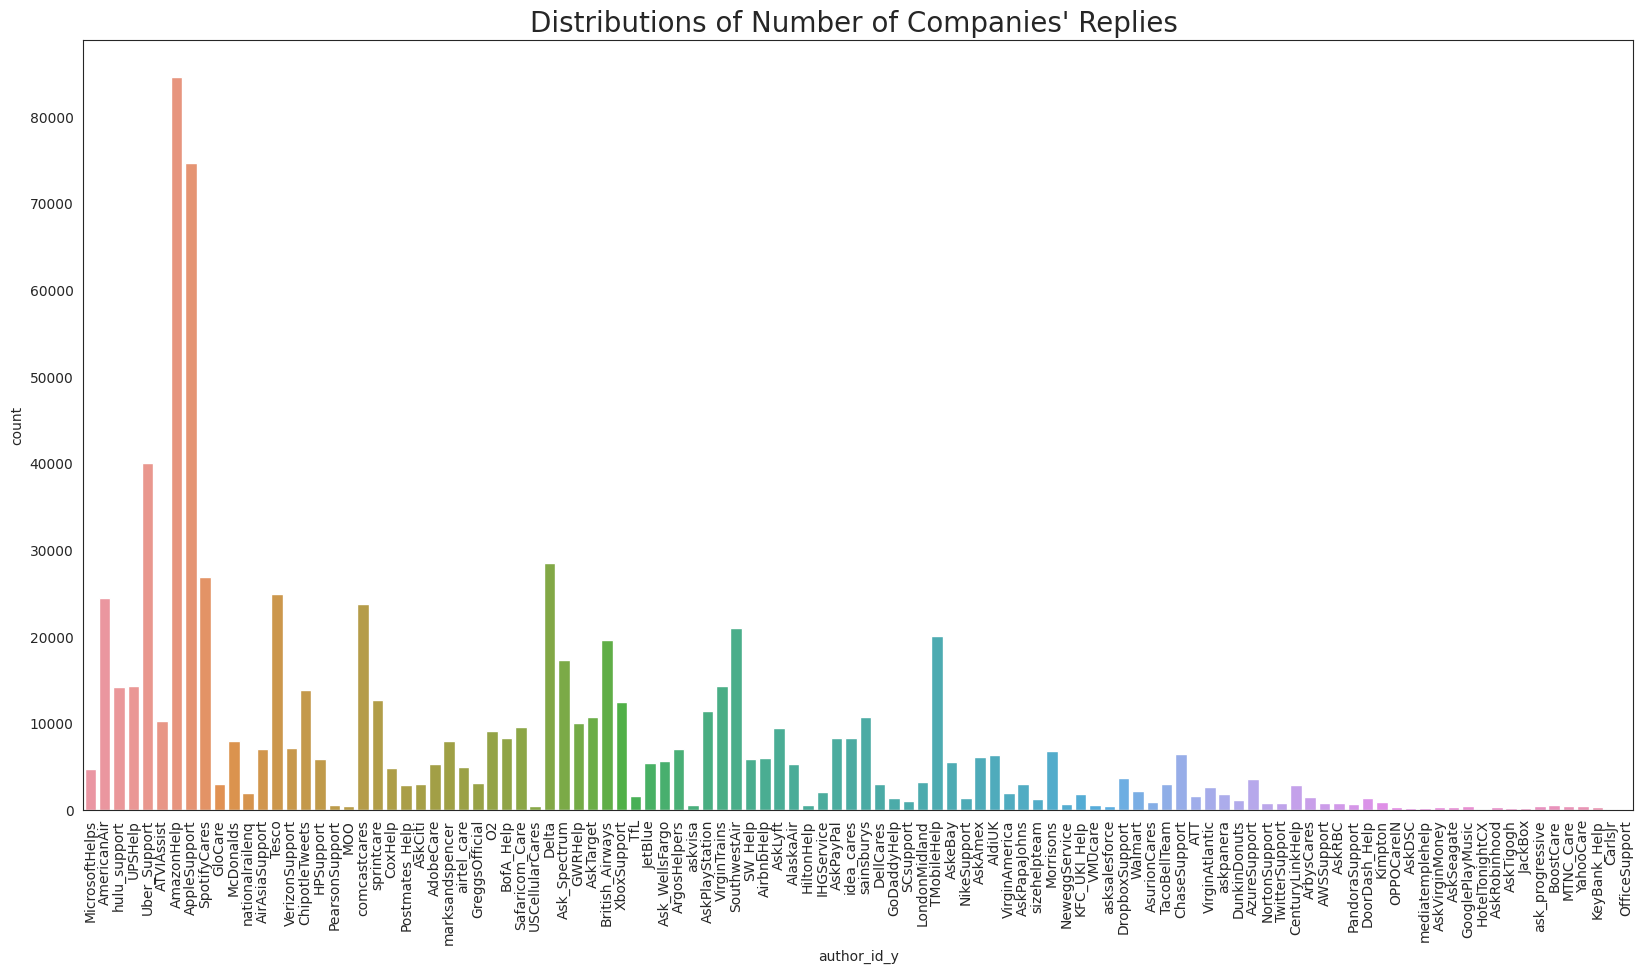

In [18]:
plt.figure(figsize=(20, 10))
sns.set_style('white')
sns.countplot(x='author_id_y', data=inbound )
plt.xticks(rotation = 90)
plt.title("Distributions of Number of Companies' Replies ", fontsize = 20)
plt.show()

# 3. Text Processing

In [19]:
inbound.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794299 entries, 650052 to 61181
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   author_id_x   794299 non-null  object
 1   created_at_x  794299 non-null  object
 2   text_x        794299 non-null  object
 3   author_id_y   794299 non-null  object
 4   created_at_y  794299 non-null  object
 5   text_y        794299 non-null  object
dtypes: object(6)
memory usage: 42.4+ MB


In [20]:
inbound.shape

(794299, 6)

## 3.1 Lower case
- 소문자로 변환

In [21]:
# 소문자로 변환하는 함수 정의
def remove_uppercase(text):
    text_lowercase = ' '.join(x.lower() for x in text.split())
    return text_lowercase

In [22]:
# 'text_x', 'text_y', 'author_id_y' 열의 값을 소문자로 변환하여 새로운 열에 저장
inbound['text_x_clean'] = inbound['text_x'].apply(lambda x: remove_uppercase(x))
inbound['text_y_clean'] = inbound['text_y'].apply(lambda x: remove_uppercase(x))

inbound['author_id_y'] = inbound['author_id_y'].apply(lambda x: remove_uppercase(x))

In [23]:
inbound.head(3)

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,text_x_clean,text_y_clean
650052,655594,Tue Nov 14 10:50:59 +0000 2017,Fingers crossed for #Windows10 creator updatin...,microsofthelps,Tue Nov 14 12:28:26 +0000 2017,@655594 How's the new update? If you have any ...,fingers crossed for #windows10 creator updatin...,@655594 how's the new update? if you have any ...
532984,564174,Wed Oct 18 12:08:57 +0000 2017,And this is why I only fly @SouthwestAir..sitt...,americanair,Wed Oct 18 12:14:06 +0000 2017,@564174 We'll be wheels up and on our way as q...,and this is why i only fly @southwestair..sitt...,@564174 we'll be wheels up and on our way as q...
53756,165112,Sun Nov 19 15:46:13 +0000 2017,@115940 i have spotify premium for students an...,hulu_support,Sun Nov 19 17:15:30 +0000 2017,"@165112 Sorry to hear about this, Ryann! Chat ...",@115940 i have spotify premium for students an...,"@165112 sorry to hear about this, ryann! chat ..."


## 3.2 Remove Punctuation
- 문장부호 및 특수문자 제거

In [24]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [25]:
#문장부호 제거하는 함수 정의
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

In [26]:
inbound['text_x_clean'] = inbound['text_x_clean'].apply(lambda x: remove_punct(x))
inbound['text_y_clean'] = inbound['text_y_clean'].apply(lambda x: remove_punct(x))

In [27]:
inbound.head(3)

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,text_x_clean,text_y_clean
650052,655594,Tue Nov 14 10:50:59 +0000 2017,Fingers crossed for #Windows10 creator updatin...,microsofthelps,Tue Nov 14 12:28:26 +0000 2017,@655594 How's the new update? If you have any ...,fingers crossed for windows10 creator updating...,655594 hows the new update if you have any que...
532984,564174,Wed Oct 18 12:08:57 +0000 2017,And this is why I only fly @SouthwestAir..sitt...,americanair,Wed Oct 18 12:14:06 +0000 2017,@564174 We'll be wheels up and on our way as q...,and this is why i only fly southwestairsitting...,564174 well be wheels up and on our way as qui...
53756,165112,Sun Nov 19 15:46:13 +0000 2017,@115940 i have spotify premium for students an...,hulu_support,Sun Nov 19 17:15:30 +0000 2017,"@165112 Sorry to hear about this, Ryann! Chat ...",115940 i have spotify premium for students and...,165112 sorry to hear about this ryann chat wit...


## 3.3 Removing usernames

In [28]:
companies = inbound['author_id_y'].unique()

In [29]:
# 'text_x_clean', 'text_y_clean'열의 숫자를 공백으로 대체
inbound['text_x_clean'] = inbound['text_x_clean'].str.replace('\d+', '', regex=False)
inbound['text_y_clean'] = inbound['text_y_clean'].str.replace('\d+', '', regex=False)

In [30]:
inbound['text_x_clean'] = inbound['text_x_clean'].str.replace('|'.join(companies), '', regex=False)
inbound['text_y_clean'] = inbound['text_y_clean'].str.replace('|'.join(companies), '', regex=False)

In [31]:
inbound.head(3)

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,text_x_clean,text_y_clean
650052,655594,Tue Nov 14 10:50:59 +0000 2017,Fingers crossed for #Windows10 creator updatin...,microsofthelps,Tue Nov 14 12:28:26 +0000 2017,@655594 How's the new update? If you have any ...,fingers crossed for windows10 creator updating...,655594 hows the new update if you have any que...
532984,564174,Wed Oct 18 12:08:57 +0000 2017,And this is why I only fly @SouthwestAir..sitt...,americanair,Wed Oct 18 12:14:06 +0000 2017,@564174 We'll be wheels up and on our way as q...,and this is why i only fly southwestairsitting...,564174 well be wheels up and on our way as qui...
53756,165112,Sun Nov 19 15:46:13 +0000 2017,@115940 i have spotify premium for students an...,hulu_support,Sun Nov 19 17:15:30 +0000 2017,"@165112 Sorry to hear about this, Ryann! Chat ...",115940 i have spotify premium for students and...,165112 sorry to hear about this ryann chat wit...


In [32]:
inbound.shape

(794299, 8)

## 3.4 Checking Most Common Words
- 빈도수 계산

In [33]:
# 가장 빈도가 높은 상위 10개 단어를 Series로 저장
freqX = pd.Series(' '.join(inbound['text_x_clean']).split()).value_counts()[:10]
freqY = pd.Series(' '.join(inbound['text_y_clean']).split()).value_counts()[:10]
print('FREQ X: \n',freqX,'\nFREQ Y: \n', freqY)

FREQ X: 
 to     450723
i      401971
the    394010
my     310504
a      288350
and    250510
is     210684
for    199852
on     184294
you    172929
dtype: int64 
FREQ Y: 
 to      596983
you     562749
the     438521
your    355910
we      300919
us      281664
for     280714
can     262526
a       256736
this    245723
dtype: int64


In [34]:
# 저장한 단어들을 제거
freqX = list(freqX.index)
freqY = list(freqY.index)
inbound['text_x_clean'] = inbound['text_x_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freqX))
inbound['text_y_clean'] = inbound['text_y_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freqY))

## 3.5 Checking Most Rare Words

In [35]:
# 가장 적게 등장한 100개의 단어를 Series로 저장
rareX = pd.Series(' '.join(inbound['text_x_clean']).split()).value_counts()[-100:]
rareY = pd.Series(' '.join(inbound['text_y_clean']).split()).value_counts()[-100:]
print('RARE X: \n',rareX,'\nRARE Y: \n', rareY)

RARE X: 
 howdairyyou           1
httpstcoxipl469bnq    1
churnedoff            1
waitedallyear         1
httpstcoqq4hd0ei2c    1
                     ..
delegaciones          1
macmail               1
wellick               1
released🤷🏽‍♀️wtf      1
httpstco6yzpsegdh7    1
Length: 100, dtype: int64 
RARE Y: 
 270702                1
682329                1
httpstcoalyxf9kali    1
502712                1
567470                1
                     ..
£1420                 1
682081                1
478215                1
youye                 1
171957                1
Length: 100, dtype: int64


In [36]:
# 저장한 단어들을 제거
rareX = list(rareX.index)
rareY = list(rareY.index)
inbound['text_x_clean'] = inbound['text_x_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in rareX))
inbound['text_y_clean'] = inbound['text_y_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in rareY))

## 3.6 Tokenizing

In [37]:
import re

# 토큰화하는 함수 정의
def tokenize(text):
    tokens = re.split('\W+', text) #W+ = 단어 문자(A-Za-z0-9_) or dash(-)가 있는 위치에서 문자열 분리
    return tokens

In [38]:
# 'text_x_clean', 'text_y_clean'열의 텍스트 데이터를 소문자로 변환 후, 단어 단위로 토큰화하여 저장
inbound['text_x_tokenized'] = inbound['text_x_clean'].apply(lambda x: tokenize(x.lower()))
inbound['text_y_tokenized'] = inbound['text_y_clean'].apply(lambda x: tokenize(x.lower()))

In [39]:
inbound.head(3)

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,text_x_clean,text_y_clean,text_x_tokenized,text_y_tokenized
650052,655594,Tue Nov 14 10:50:59 +0000 2017,Fingers crossed for #Windows10 creator updatin...,microsofthelps,Tue Nov 14 12:28:26 +0000 2017,@655594 How's the new update? If you have any ...,fingers crossed windows10 creator updating wor...,655594 hows new update if have any questions f...,"[fingers, crossed, windows10, creator, updatin...","[655594, hows, new, update, if, have, any, que..."
532984,564174,Wed Oct 18 12:08:57 +0000 2017,And this is why I only fly @SouthwestAir..sitt...,americanair,Wed Oct 18 12:14:06 +0000 2017,@564174 We'll be wheels up and on our way as q...,this why only fly southwestairsitting runway a...,564174 well be wheels up and on our way as qui...,"[this, why, only, fly, southwestairsitting, ru...","[564174, well, be, wheels, up, and, on, our, w..."
53756,165112,Sun Nov 19 15:46:13 +0000 2017,@115940 i have spotify premium for students an...,hulu_support,Sun Nov 19 17:15:30 +0000 2017,"@165112 Sorry to hear about this, Ryann! Chat ...",115940 have spotify premium students ive used ...,165112 sorry hear about ryann chat with here h...,"[115940, have, spotify, premium, students, ive...","[165112, sorry, hear, about, ryann, chat, with..."


## 3.7 Remove StopWords
- 불용어 제거

In [40]:
import nltk                # Natural Language Toolkit
nltk.download('stopwords') # 불용어 데이터 다운로드

stopword = nltk.corpus.stopwords.words('english') # 영어의 불용어를 저장

# 불용어 제거하는 함수 정의
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]
    return text

# 'text_x_tokenized','text_y_tokenized'열의 불용어 제거
inbound['text_x_tokenized'] = inbound['text_x_tokenized'].apply(lambda x: remove_stopwords(x))
inbound['text_y_tokenized'] = inbound['text_y_tokenized'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [41]:
inbound.head(3)

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,text_x_clean,text_y_clean,text_x_tokenized,text_y_tokenized
650052,655594,Tue Nov 14 10:50:59 +0000 2017,Fingers crossed for #Windows10 creator updatin...,microsofthelps,Tue Nov 14 12:28:26 +0000 2017,@655594 How's the new update? If you have any ...,fingers crossed windows10 creator updating wor...,655594 hows new update if have any questions f...,"[fingers, crossed, windows10, creator, updatin...","[655594, hows, new, update, questions, feel, f..."
532984,564174,Wed Oct 18 12:08:57 +0000 2017,And this is why I only fly @SouthwestAir..sitt...,americanair,Wed Oct 18 12:14:06 +0000 2017,@564174 We'll be wheels up and on our way as q...,this why only fly southwestairsitting runway a...,564174 well be wheels up and on our way as qui...,"[fly, southwestairsitting, runway, bwi, waitin...","[564174, well, wheels, way, quickly, appreciat..."
53756,165112,Sun Nov 19 15:46:13 +0000 2017,@115940 i have spotify premium for students an...,hulu_support,Sun Nov 19 17:15:30 +0000 2017,"@165112 Sorry to hear about this, Ryann! Chat ...",115940 have spotify premium students ive used ...,165112 sorry hear about ryann chat with here h...,"[115940, spotify, premium, students, ive, used...","[165112, sorry, hear, ryann, chat, httpstco6yd..."


## 3.8 Stemming 어간 추출 vs Lemmatizing 표제어 추출
- 어간 추출은 단어의 맥락을 이해하지 않고 단순히 단어의 끝을 잘라내기 때문에 속도가 빠름
- 표제어 추출은 단어의 맥락을 염두에 두고 분석하기 때문에 느리지만 더 정확함

## 3.9 Lemmatizing
- 표제어 추출

In [42]:
wn = nltk.WordNetLemmatizer()
nltk.download('wordnet')

def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [43]:
inbound['text_x_lemmatized'] = inbound['text_x_tokenized'].apply(lambda x: lemmatizing(x))
inbound['text_y_lemmatized'] = inbound['text_y_tokenized'].apply(lambda x: lemmatizing(x))

In [44]:
inbound.head(3)

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,text_x_clean,text_y_clean,text_x_tokenized,text_y_tokenized,text_x_lemmatized,text_y_lemmatized
650052,655594,Tue Nov 14 10:50:59 +0000 2017,Fingers crossed for #Windows10 creator updatin...,microsofthelps,Tue Nov 14 12:28:26 +0000 2017,@655594 How's the new update? If you have any ...,fingers crossed windows10 creator updating wor...,655594 hows new update if have any questions f...,"[fingers, crossed, windows10, creator, updatin...","[655594, hows, new, update, questions, feel, f...","[finger, crossed, windows10, creator, updating...","[655594, hows, new, update, question, feel, fr..."
532984,564174,Wed Oct 18 12:08:57 +0000 2017,And this is why I only fly @SouthwestAir..sitt...,americanair,Wed Oct 18 12:14:06 +0000 2017,@564174 We'll be wheels up and on our way as q...,this why only fly southwestairsitting runway a...,564174 well be wheels up and on our way as qui...,"[fly, southwestairsitting, runway, bwi, waitin...","[564174, well, wheels, way, quickly, appreciat...","[fly, southwestairsitting, runway, bwi, waitin...","[564174, well, wheel, way, quickly, appreciate..."
53756,165112,Sun Nov 19 15:46:13 +0000 2017,@115940 i have spotify premium for students an...,hulu_support,Sun Nov 19 17:15:30 +0000 2017,"@165112 Sorry to hear about this, Ryann! Chat ...",115940 have spotify premium students ive used ...,165112 sorry hear about ryann chat with here h...,"[115940, spotify, premium, students, ive, used...","[165112, sorry, hear, ryann, chat, httpstco6yd...","[115940, spotify, premium, student, ive, used,...","[165112, sorry, hear, ryann, chat, httpstco6yd..."


# 4. Count Vectorizer
- 텍스트 데이터를 단어 빈도 기반의 숫자 벡터로 변환

In [46]:
# scikit-learn 라이브러리에서 'CountVectorizer' 클래스 가져오기
from sklearn.feature_extraction.text import CountVectorizer

In [47]:
questions = inbound['text_x_clean'].dropna()
q = np.array(questions)

In [49]:
countV = CountVectorizer(stop_words='english',
                         max_features=10000)

# 'q'에 있는 문서들을 Bag-of-Words 형식으로 변환 -> 피어 벡터로 변환하여 저장
bagQuestions = countV.fit_transform(q)

print('BOW Questions: ',bagQuestions.shape)

BOW Questions:  (794299, 10000)


# 5. Wordcloud with the most common words in customer requests

In [51]:
# 텍스트 데이터를 Bag-of-Words 형식으로 변환,
# 단어들의 빈도를 계산하여 내림차순으로 정렬, 딕셔너리로 저장
# 단어들의 빈도 정보를 쉽게 확인하거나 다양한 텍스트 분석 작업에 활용할 수 있음

words = countV.get_feature_names_out()
total_counts = np.zeros(len(words))
for t in bagQuestions:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)
d = dict(count_dict)

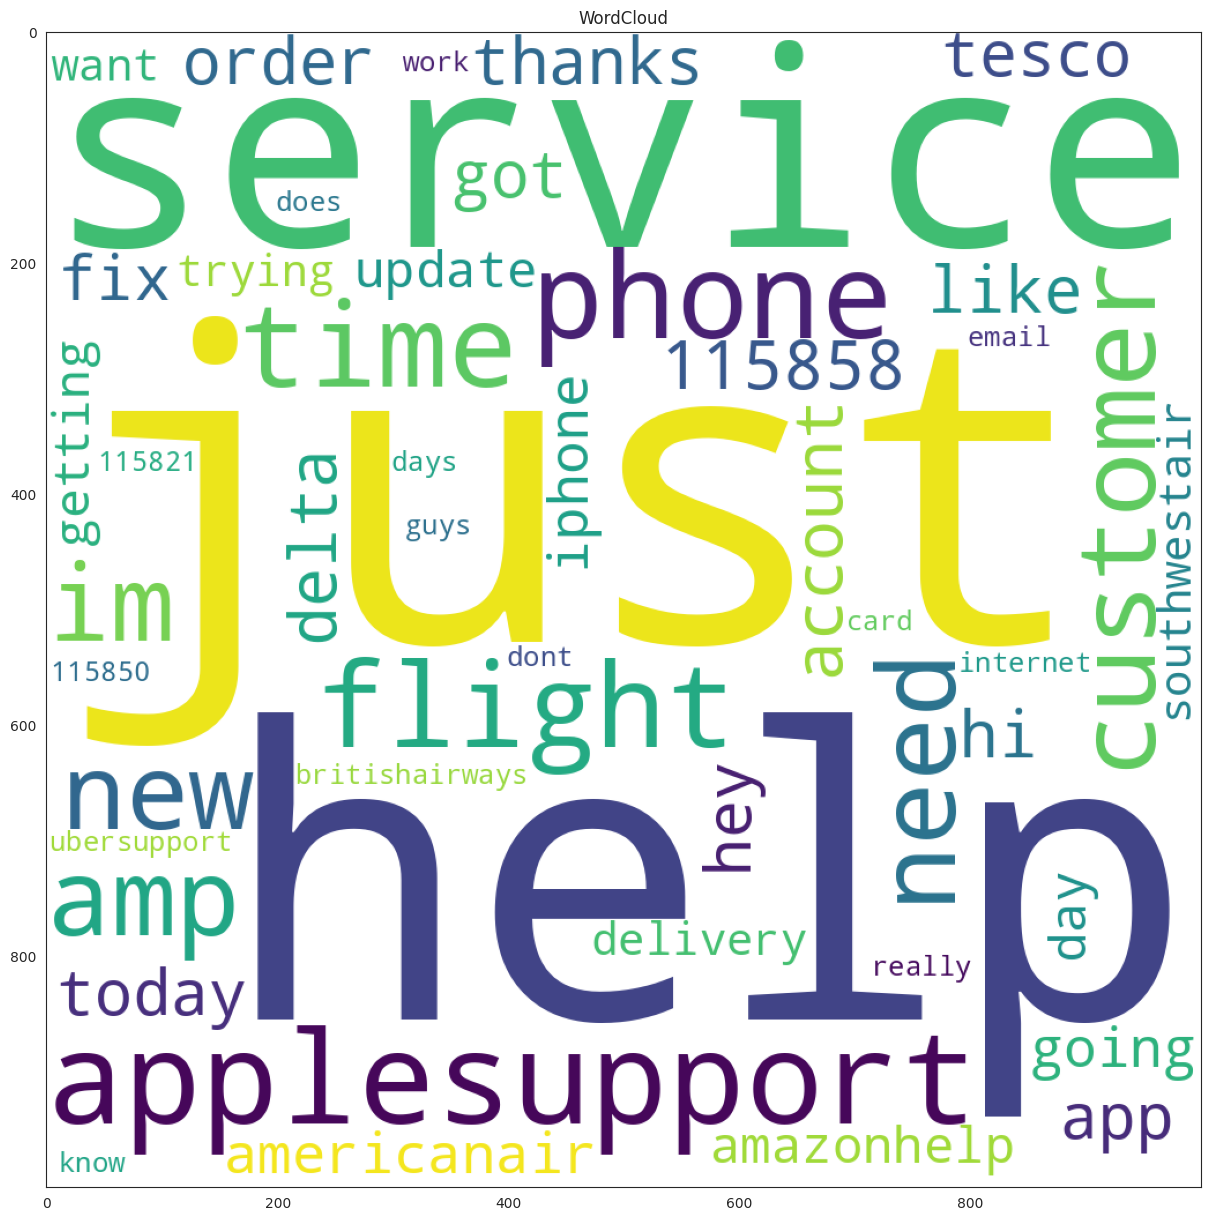

In [52]:
from wordcloud import WordCloud

sns.set_style('white')
plt.figure(figsize=(15,15))
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=50,
               relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(d)
plt.title('WordCloud')
plt.imshow(wc)
plt.show()